# Max 2-Sat

For the problem representation we used a standard format, widely accepted for boolean formulas in CNF, called [DIMACS](https://www.cs.utexas.edu/users/moore/acl2/manuals/current/manual/index-seo.php/SATLINK____DIMACS).

`usage` : change `PATH` variable, in the cell containing parameters, to choose the file of the problem you want to solve



In [3]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from neal import SimulatedAnnealingSampler

import numpy as np
import dwavebinarycsp
import dimod
import itertools 
import minorminer
import networkx as nx
import dwave_networkx as dnx

In [4]:
# parameters

TOKEN = 'DEV-dadab771e1ad528a25146defb4c58b1e0fe50b33' # API dwave
PATH = 'testing_sat/benchmarks/s2v120c1300-1.cnf' # current problem to solve
SAT_PATH = 'testing_sat/'
NUM_READS_SQA = 20
NUM_READS_QPU = 20

# Create QUBO

In order to create the QUBO of a MAX 2 SAT problem we followed [Glover 2019](https://arxiv.org/pdf/1811.11538.pdf). The formulas to convert traditional constraints into quadratic penalties can be found on page 15:


1. No negations: 
    Example $\left(x_{i} \vee x_{j}\right)$ 
    * Traditional constraint: $x_{i}+x_{j} \geq 1$ 
    * Quadratic Penalty: $\left(1-x_{i}-x_{j}+x_{i} x_{j}\right)$
2. One negation:
    Example $\left(x_{i} \vee \bar{x}_{j}\right)$
    * Traditional constraint: $x_{i}+\bar{x}_{j} \geq 1$
    * Quadratic Penalty: $\left(x_{j}-x_{i} x_{j}\right)$
3. Two negations: 
    Example $\left(\bar{x}_{i} \vee \bar{x}_{j}\right)$ 
    * Traditional constraint: $\bar{x}_{i}+\bar{x}_{j} \geq 1$
    * Quadratic Penalty: $\left(x_{i} x_{j}\right)$


In [9]:
# extract clauses and num of variables from 
def extract_clauses(path):
    with open(path, "r") as f:
        # retrieve data from file
        sat = f.readlines()
        data = sat[0].split(" ")

    n_variables = int(data[2]) 

    sat = sat[1:]
    clauses = [x.replace(' 0\n', '') for x in sat]
    
    return clauses, n_variables

clauses, n_variables = extract_clauses(PATH) 
print(f'num_clauses {len(clauses)}')
print('-' * 30)  
print(f'num var {n_variables}')  
print('-' * 30)  
#print(f'clauses {clauses}')  

num_clauses 1300
------------------------------
num var 120
------------------------------


In [11]:
# generate the matrix Q and c

def gen_q(clauses, n_variables):
    
    Q = np.zeros(shape=(n_variables, n_variables))
    c = 0
    QUBO_graph = nx.Graph()
    for clause in clauses:
        clause = clause.split(' ')
        int_clause = [int(c) for c in clause]

        s1, s2 = int_clause[0], int_clause[1]
        v1, v2 = abs(s1)-1, abs(s2)-1
        QUBO_graph.add_edge(abs(s1), abs(s2))

        if s1 > 0 and s2 > 0: # True True
            # 1 - x1 - x2 + x1x2
            c += 1
            Q[v1][v1] += -1 
            Q[v2][v2] += -1
            Q[v1][v2] += 1/2 
            Q[v2][v1] += 1/2
        elif s1 > 0 and s2 < 0: # True False
            # x2 - x1x2
            Q[v2][v2] += 1
            Q[v1][v2] += -1/2 
            Q[v2][v1] += -1/2

        elif s1 < 0 and s2 > 0: # False True
            # x1 - x1x2
            Q[v1][v1] += 1
            Q[v1][v2] += -1/2 
            Q[v2][v1] += -1/2

        elif s1 < 0 and s2 < 0: # False False
            # x1x2
            Q[v1][v2] += 1/2 
            Q[v2][v1] += 1/2

        else:
            pass # throw error
            
    return Q, c, QUBO_graph

Q, c, QUBO_graph = gen_q(clauses, n_variables)

print(f'Q is: \n{Q}')
print('-' * 40)
print(f'c is: {c}')


Q is: 
[[-6.  -0.5  0.  ... -0.5  0.   0. ]
 [-0.5  2.   0.  ...  0.   0.5  0. ]
 [ 0.   0.  -3.  ...  0.   0.   0. ]
 ...
 [-0.5  0.   0.  ... -2.   0.   0.5]
 [ 0.   0.5  0.  ...  0.  -4.   0.5]
 [ 0.   0.   0.  ...  0.5  0.5  1. ]]
----------------------------------------
c is 339


## Create BQM

In [13]:
# Create BQM
variable_order = ["x_{}".format(n) for n in range(1, n_variables+1)]
BQM = dimod.BinaryQuadraticModel.from_numpy_matrix(Q, variable_order = variable_order)
# BQM

# Solve

We now solve the problem through both simulated and real quantum annealing showing the results obtained.  

In [14]:
def print_response_data(response):
    # ------- Print results to user -------
    print('-' * 160)
    print('{:>40s}{:>40s}{:^40s}{:^40s}'.format('Set 0','Set 1','Energy',"Count"))
    print('-' * 160)
    for sample, E, occ in response.data(fields=['sample','energy',"num_occurrences"]):
        S0 = [k for k,v in sample.items() if v == 0]
        S1 = [k for k,v in sample.items() if v == 1]
        print('{:>40s}{:>40s}{:^40s}{:^40s}'.format(str(S0),str(S1),str(E),str(occ)))

## Simulated Quantum Annealing

In [15]:
def simulated_annealing(bqm, num_reads_sa=NUM_READS_SQA):
    # Run the QUBO on the solver from your config file
    sampler = SimulatedAnnealingSampler()
    response_SQA = sampler.sample(bqm, num_reads=num_reads_sa)
    return response_SQA

## Real Quantum Annealing

In [16]:
def real_annealing(bqm, num_reads_qpu=NUM_READS_QPU, token=TOKEN):
    # Run the QUBO on the solver from your config file
    sampler = EmbeddingComposite(DWaveSampler(token=token))

    response_QPU = sampler.sample(bqm, num_reads=num_reads_qpu)
    return response_QPU

# Results
In the result we select the most frequent solution and we show both the optimal number of unsatisfied constraints and the assignment of the optimal solution

In [17]:
# retrieve result with the best counts

def return_solution(response, Q, c):
    count = 0
    for i in range(len(response)):
        new_count = response[i][2]
        if  new_count > count:
            best = response[i][0]
            count = new_count
    
    y = c + np.matmul(np.matmul(best.T, Q), best) 

    return y, best

def print_solution(response, Q, c):
    y, best = return_solution(response_SQA.aggregate().record, Q, c)
    print(f'y is {int(y)} (optimal number of unsitisfied constraints)')

    for v in range(n_variables):
        print(f'x_{v+1} = {True if best[v] else False}')
    

## Simulated Quantum Annealing

In [18]:
response_SQA = simulated_annealing(BQM)

In [19]:
print_response_data(response_SQA.aggregate()) # FIXME: long print

', 'x_101', 'x_102', 'x_105', 'x_11', 'x_113', 'x_12', 'x_120', 'x_13', 'x_14', 'x_15', 'x_16', 'x_18', 'x_20', 'x_24', 'x_26', 'x_27', 'x_28', 'x_29', 'x_3', 'x_30', 'x_31', 'x_34', 'x_35', 'x_36', 'x_38', 'x_39', 'x_4', 'x_40', 'x_45', 'x_49', 'x_5', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_56', 'x_58', 'x_59', 'x_60', 'x_62', 'x_66', 'x_69', 'x_7', 'x_71', 'x_72', 'x_76', 'x_79', 'x_80', 'x_81', 'x_82', 'x_83', 'x_84', 'x_87', 'x_88', 'x_89', 'x_9', 'x_94', 'x_95', 'x_96', 'x_97', 'x_98']['x_1', 'x_10', 'x_103', 'x_104', 'x_106', 'x_107', 'x_108', 'x_109', 'x_110', 'x_111', 'x_112', 'x_114', 'x_115', 'x_116', 'x_117', 'x_118', 'x_119', 'x_17', 'x_19', 'x_2', 'x_21', 'x_22', 'x_23', 'x_25', 'x_32', 'x_33', 'x_37', 'x_41', 'x_42', 'x_43', 'x_44', 'x_46', 'x_47', 'x_48', 'x_55', 'x_57', 'x_6', 'x_61', 'x_63', 'x_64', 'x_65', 'x_67', 'x_68', 'x_70', 'x_73', 'x_74', 'x_75', 'x_77', 'x_78', 'x_8', 'x_85', 'x_86', 'x_90', 'x_91', 'x_92', 'x_93', 'x_99']                 -159.0            

In [20]:
print_solution(response_SQA, Q, c)

y is 359 (optimal number of unsitisfied constraints)
x_1 = True
x_2 = True
x_3 = False
x_4 = True
x_5 = False
x_6 = True
x_7 = True
x_8 = False
x_9 = True
x_10 = True
x_11 = True
x_12 = True
x_13 = False
x_14 = True
x_15 = True
x_16 = True
x_17 = False
x_18 = True
x_19 = True
x_20 = True
x_21 = True
x_22 = True
x_23 = True
x_24 = False
x_25 = False
x_26 = False
x_27 = False
x_28 = True
x_29 = False
x_30 = True
x_31 = False
x_32 = True
x_33 = True
x_34 = False
x_35 = True
x_36 = True
x_37 = True
x_38 = False
x_39 = True
x_40 = False
x_41 = False
x_42 = False
x_43 = False
x_44 = False
x_45 = True
x_46 = False
x_47 = True
x_48 = True
x_49 = False
x_50 = False
x_51 = True
x_52 = True
x_53 = False
x_54 = False
x_55 = False
x_56 = False
x_57 = True
x_58 = True
x_59 = True
x_60 = True
x_61 = False
x_62 = True
x_63 = True
x_64 = True
x_65 = False
x_66 = False
x_67 = False
x_68 = False
x_69 = True
x_70 = False
x_71 = False
x_72 = True
x_73 = False
x_74 = True
x_75 = False
x_76 = False
x_77 = Tr

## Real Quantum Annealing


In [23]:
response_QPU = real_annealing(BQM)

In [68]:
print_response_data(response_QPU) # FIXME: long print

', 'x_101', 'x_102', 'x_105', 'x_107', 'x_11', 'x_111', 'x_113', 'x_118', 'x_120', 'x_13', 'x_14', 'x_15', 'x_16', 'x_18', 'x_20', 'x_25', 'x_27', 'x_28', 'x_29', 'x_31', 'x_33', 'x_34', 'x_35', 'x_4', 'x_40', 'x_45', 'x_48', 'x_49', 'x_5', 'x_50', 'x_53', 'x_54', 'x_55', 'x_56', 'x_58', 'x_59', 'x_62', 'x_63', 'x_66', 'x_68', 'x_71', 'x_72', 'x_79', 'x_80', 'x_82', 'x_83', 'x_84', 'x_85', 'x_86', 'x_87', 'x_88', 'x_89', 'x_9', 'x_96', 'x_97', 'x_98', 'x_99']['x_1', 'x_10', 'x_103', 'x_104', 'x_106', 'x_108', 'x_109', 'x_110', 'x_112', 'x_114', 'x_115', 'x_116', 'x_117', 'x_119', 'x_12', 'x_17', 'x_19', 'x_2', 'x_21', 'x_22', 'x_23', 'x_24', 'x_26', 'x_3', 'x_30', 'x_32', 'x_36', 'x_37', 'x_38', 'x_39', 'x_41', 'x_42', 'x_43', 'x_44', 'x_46', 'x_47', 'x_51', 'x_52', 'x_57', 'x_6', 'x_60', 'x_61', 'x_64', 'x_65', 'x_67', 'x_69', 'x_7', 'x_70', 'x_73', 'x_74', 'x_75', 'x_76', 'x_77', 'x_78', 'x_8', 'x_81', 'x_90', 'x_91', 'x_92', 'x_93', 'x_94', 'x_95']                 -144.0            

In [69]:
print_solution(response_QPU, Q, c)

y is 349 (optimal number of unsitisfied constraints)
x_1 = True
x_2 = True
x_3 = False
x_4 = True
x_5 = False
x_6 = True
x_7 = True
x_8 = False
x_9 = True
x_10 = True
x_11 = True
x_12 = True
x_13 = False
x_14 = True
x_15 = True
x_16 = True
x_17 = False
x_18 = True
x_19 = True
x_20 = True
x_21 = True
x_22 = True
x_23 = True
x_24 = False
x_25 = False
x_26 = False
x_27 = False
x_28 = True
x_29 = False
x_30 = True
x_31 = False
x_32 = True
x_33 = True
x_34 = False
x_35 = True
x_36 = True
x_37 = True
x_38 = True
x_39 = True
x_40 = False
x_41 = False
x_42 = False
x_43 = False
x_44 = False
x_45 = False
x_46 = False
x_47 = True
x_48 = True
x_49 = False
x_50 = False
x_51 = True
x_52 = True
x_53 = False
x_54 = False
x_55 = False
x_56 = False
x_57 = True
x_58 = True
x_59 = True
x_60 = True
x_61 = False
x_62 = True
x_63 = True
x_64 = True
x_65 = False
x_66 = False
x_67 = False
x_68 = False
x_69 = True
x_70 = False
x_71 = False
x_72 = True
x_73 = False
x_74 = True
x_75 = False
x_76 = False
x_77 = Tr

# Model Features

## Number of required Qubits

In [70]:
device = DWaveSampler(token=TOKEN)
device.solver.data['id']

QPU_graph = device.solver.data['properties']["couplers"]

embedded_graph = minorminer.find_embedding(QUBO_graph.edges(), QPU_graph)

embedded_graph # FIXME: long print

{16: [1280,
  1281,
  1282,
  1283,
  1279,
  1278,
  1277,
  1276,
  3891,
  3890,
  964,
  3829,
  1284],
 60: [1340, 1339, 1338, 1341, 1342, 3892, 1343, 3576, 1337, 1336],
 28: [888,
  887,
  3184,
  3874,
  4684,
  889,
  4685,
  890,
  4686,
  891,
  4687,
  892,
  4688,
  893,
  1005,
  886,
  4689,
  894,
  1779,
  3709],
 56: [3430,
  3429,
  3428,
  2042,
  3427,
  3425,
  3424,
  3491,
  2178,
  2179,
  2180,
  1607,
  3656,
  3911,
  3426],
 94: [3863,
  3862,
  3864,
  3865,
  3866,
  1985,
  3861,
  3860,
  3859,
  2134,
  3858,
  1969,
  1986,
  3746],
 13: [1777, 4239, 1778, 1776, 1775, 1774, 4238, 4237, 4236, 3954, 1773],
 66: [1324, 3771, 1323, 3770, 1322, 1325, 1326, 1327, 1321, 1328, 1320],
 49: [846, 845, 844, 842, 841, 847, 4369, 4219, 4220, 848, 3753, 843],
 111: [1401,
  4177,
  1399,
  4175,
  1448,
  1398,
  4174,
  1447,
  1397,
  1449,
  1400,
  4176,
  1396,
  1395],
 34: [4524,
  4525,
  4526,
  4527,
  4519,
  2423,
  4523,
  2422,
  4522,
  2421,
  4521,


In [71]:
sublist = [values for keys, values in embedded_graph.items()]
flat_list = set(itertools.chain(*sublist))    

max_chain_length = None
min_chain_length = None

for _, chain in embedded_graph.items():
    if max_chain_length is None:
        max_chain_length = len(chain)
        min_chain_length = len(chain)

    if len(chain) > max_chain_length:
        max_chain_length = len(chain)

    if len(chain) < min_chain_length:
        min_chain_length = len(chain)

    
print("Embedding requires {} qubits and has chain lengths between {}-{}".format(len(flat_list),min_chain_length, max_chain_length))

Embedding requires 1644 qubits and has chain lengths between 4-22


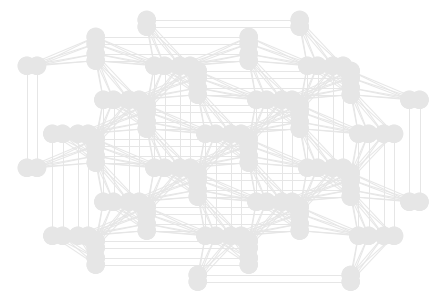

In [72]:
# find an embedding on Pegasus using minorminer
connectivity_structure = dnx.pegasus_graph(3)
embedded_graph = minorminer.find_embedding(QUBO_graph.edges(), connectivity_structure.edges())

# plot this emebedding
dnx.draw_pegasus_embedding(connectivity_structure, embedded_graph, with_labels=False)
# plt.savefig("pegasus_embedding_max_cut.png", bbox_inches='tight', dpi=4200)

# Testing

In [44]:
# define the csp
csp = dwavebinarycsp.factories.random_2in4sat(4, 2) # 8 variables, 4 clauses
csp

In [45]:
# define the csp
csp = dwavebinarycsp.factories.random_2in4sat(4, 2) 
print(type(csp))
for i in range(len(csp.constraints)):
    print(csp.constraints[i])

# generate the bqm from the csp
import warnings
np.warnings.filterwarnings("ignore", category=DeprecationWarning)

bqm = dwavebinarycsp.stitch(csp)
bqm

<class 'dwavebinarycsp.core.csp.ConstraintSatisfactionProblem'>
Constraint.from_configurations(frozenset({(0, 1, 0, 1), (1, 1, 0, 0), (0, 1, 1, 0), (1, 0, 1, 0), (1, 0, 0, 1), (0, 0, 1, 1)}), (0, 1, 2, 3), Vartype.BINARY, name='2-in-4')
Constraint.from_configurations(frozenset({(0, 1, 0, 1), (0, 1, 1, 0), (1, 0, 1, 0), (0, 0, 0, 0), (1, 0, 0, 1), (1, 1, 1, 1)}), (0, 2, 1, 3), Vartype.BINARY, name='2-in-4')


BinaryQuadraticModel({0: -4.0, 1: -4.0, 2: -4.0, 3: -4.0}, {(0, 1): 0.0, (0, 2): 8.0, (0, 3): 0.0, (1, 2): 0.0, (1, 3): 8.0, (2, 3): 0.0}, 8.0, 'BINARY')

In [46]:
resp_san = simulated_annealing(bqm)
#resp_qpu = real_annealing(bqm)

print_response_data(resp_san.aggregate())
print_response_data(resp_qpu.aggregate())


----------------------------------------------------------------------------------------------------------------------------------------------------------------
                                   Set 0                                   Set 1                 Energy                                  Count                  
----------------------------------------------------------------------------------------------------------------------------------------------------------------
                                  [0, 1]                                  [2, 3]                  0.0                                      5                    
                                  [1, 2]                                  [0, 3]                  0.0                                      3                    
                                  [2, 3]                                  [0, 1]                  0.0                                      7                    
                                  

NameError: name 'resp_qpu' is not defined